# Project: RoadNX QC

Mostly a debugging notebook to prepare code for usage in JavaScript's Leaflet library. The sample output below maps the paths of all fire stations to a hypothetical fire (as a point) in Quezon City. 

In [1]:
import psycopg2
import networkx as nx
import osmnx as osx
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point,Polygon,LineString
import matplotlib.pyplot as plt
import folium

In [3]:
conn = psycopg2.connect(dbname="aadeleon", 
                 user="aadeleon", 
                 password="", 
                 host="127.0.0.1", 
                 port=5432)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


# Extract Geometry of Building

In [4]:
# q = """
#     --select * 
#     --from pg_tables
#     --where schemaname = 'public'
#     select amenity, name, area, ref, other_tags,wkb_geometry
#     from public.multipolygons
#     --limit 10
#     """

# gpd.read_postgis(q, con=conn, geom_col='wkb_geometry')

## Extract Geometry of City

In [5]:
q = """
    SELECT name_2, geom
    FROM gadm.ph
    WHERE name_2 = 'Quezon City'
    """

poly = gpd.read_postgis(q, conn, geom_col='geom')
makati = poly.loc[0][1]

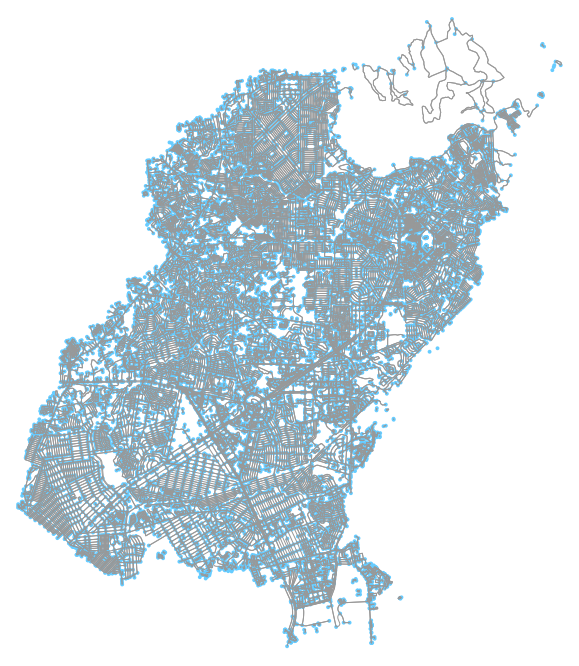

In [6]:
graph = osx.graph_from_polygon(makati, network_type='all',
                              retain_all=True)
plot = osx.plot_graph(graph, fig_height=12)

In [7]:
graph = osx.project_graph(graph, to_crs={'init': 'epsg:32651'})

In [8]:
# osx.save_graphml(graph, filename='QC_graph.graphml', gephi=True)

In [9]:
graph = osx.load_graphml('QC_graph.graphml')

## Get fire station coordinates

In [10]:
# q = """
#     SELECT *
#     FROM points
#     LIMIT 10
#     """

# pd.read_sql(q, conn)

In [11]:
q = """
    with city as (
    SELECT name_2 as x1, geom as dx
    FROM gadm.ph
    WHERE name_2 = 'Quezon City')
    
    SELECT amenity, x1, name, wkb_geometry as dy
    FROM points
    JOIN city
    ON st_within(wkb_geometry,dx)
    WHERE amenity = 'fire_station'
    AND name IS NOT NULL
    """

fs = gpd.read_postgis(q, conn, geom_col='dy')
points = fs.drop_duplicates().drop('amenity', axis=1)

In [12]:
points

,x1,name,dy
0,Quezon City,La Loma Fire Sub-station,POINT (120.99465 14.63183)
1,Quezon City,IBP Fire Sub-Station,POINT (121.09581 14.69463)
2,Quezon City,Galas Fire Sub-station,POINT (121.00917 14.61197)
3,Quezon City,Frisco Fire Sub-station,POINT (121.01884 14.65471)
4,Quezon City,Bf Fire Sub-station,POINT (121.07682 14.68971)
5,Quezon City,Fire Chiefs & Fire Fighters Group,POINT (121.02162 14.64229)
6,Quezon City,Fairview Fire Sub-station,POINT (121.07300 14.70736)
7,Quezon City,eastwood libis Fire Station 3,POINT (121.07668 14.61008)
8,Quezon City,Quezon City Fil-Chi Volunteer Fire Brigade Ass'n.,POINT (121.01772 14.61572)
9,Quezon City,"New Millenium Fire & Rescue Volunteers Assoc.,...",POINT (121.00332 14.63559)


In [13]:
# for i in points['dy']:
#     print(i)

In [14]:
fire = 14.618785, 121.055323
FS = 14.69463, 121.09581

# shortest_distance(graph, FS[::-1], fire[::-1])

In [15]:
def shortest_distance(graph, o_c, dest_c):
    """
    Creates a GeoDataFrame containing the edges of the shortest path
    from an origin to a destination point. These edges are represented 
    as linestrings that can be plotted on a map (folium works)
    
    Also prints the distance of the computed path.
    
    Parameters
    ----------
    graph : Graph 
        osmnx graph of the area containing the points
        
    o_c : tuple of floats
        coordinates of origin point in Long/Lat format
        
    dest_c : tuple of floats
        coordinates of destination point in Long/Lat format
        
    Returns
    -------
    path_gdf : GeoDataFrame
    
    shortest_dist : float
    """
    
    # Create a gdf to convert the geometry to standard crs
    
    try:
        gdf = gpd.GeoDataFrame([{"geometry": Point(o_c)},
                                {"geometry": Point(dest_c)}], 
                               crs={'init':'epsg:4326'})
        gdf.to_crs({'init': 'epsg:32651'}, inplace=True)
        origin_point = gdf.loc[0].geometry
        dest_point = gdf.loc[1].geometry

        # find the nearest node to the input points
        O = osx.get_nearest_node(graph, (origin_point.y, origin_point.x), 
                                 method='euclidean', return_dist=True)
        D = osx.get_nearest_node(graph, (dest_point.y, dest_point.x), 
                                 method='euclidean', return_dist=True)

        """
        create a dictionary of edges and their associated features
        note you can inspect the features by printing node_dict to see
        other available features""
        """   
        path = nx.shortest_path(graph, source=O[0], target=D[0])
        path_edges = []
        adj = graph.adj
        for i in range(0,len(path)-1):
            edges = adj[path[i]][path[i+1]]
            min_length = float("inf")
            min_edge = None
            for key in edges: 
                edge = edges[key]
                if edge["length"] < min_length:
                    min_length = edge["length"]
                    min_edge = edge
            path_edges.append((path[i],path[i+1],min_edge))
        node_dict = dict(graph.nodes)

        """
        generate a geodataframe to make it folium-ready
        """   
        gdf_builder = [] 
        for edge in path_edges:
            u = node_dict[edge[0]]
            v = node_dict[edge[1]]
            curr = edge[2] 
            if "geometry" not in curr: 
                geom = LineString([(u['x'],u['y']),(v['x'],v['y'])])
            else:
                geom = curr['geometry']
            res = {"source": edge[0], "target": edge[1], 
               "distance": edge[2]['length'],"geometry":geom}
            gdf_builder.append(res)
        path_gdf = gpd.GeoDataFrame(gdf_builder,crs={'init':'epsg:32651'})
        path_gdf.to_crs({'init':'epsg:4326'},inplace=True)
        path_gdf

        shortest_dist = path_gdf['distance'].sum()
    #     print('distance:', shortest_dist)

        # compute shortest path
    #     best_path = nx.shortest_path_length(graph, Point(o_c), Point(dest_c))   
        return path_gdf, shortest_dist
    except:
        print('Please choose a point closer to the road.')

In [16]:
def compute_time(speed, distance, return_minutes=True):
    """
    Parameters
    ----------
    speed : int
        speed in km/h
    distance : float
        distance in m
    """
    ms_speed = speed/3.6
    seconds = distance/ms_speed
    mins = seconds/60
    hours = mins/60
    if return_minutes:
        return round(mins, 2)
    else:
        return round(hours, 2)

In [17]:
def simulate_fire(graph, loc, dest, F_gdfs, geom_col, n):
    """
    NOTE: keep all inputs in lat/long format. 
    
    Parameters
    ----------
    loc : tuple
        center from where to make the map
        
    dest : tuple
        destination of all pts
        
    F_gdfs : GeoDataFrame
        all origin points
    """
    curr_map = folium.Map(location = loc, zoom_start=n)
    
    folium.Marker(
            location=dest,
            popup='Destination',
            icon=folium.Icon(color='red')
            ).add_to(curr_map)
    
#     gdfs = []
    dists = []
    counter = 0
    
    for index,row in F_gdfs.iterrows():
        
        F = (row[geom_col].x, row[geom_col].y)
        try:
            gdf, dist = shortest_distance(graph, F, dest[::-1])
            dists.append(dist)
            
            geo_json = gdf.to_json()
            
            if compute_time(30, dist) <= 20:
            
                path = folium.features.GeoJson(geo_json)
                path.add_to(curr_map)

                folium.Marker(
                    location=F[::-1],
                popup=row['name']).add_to(curr_map)
                
                counter += 1
            else:
                print(row['name'], 'was too far.')
#             print('added to map')
        except:
            print('location outside graph')
            
    
#     folium.Marker(location=(14.610002, 121.076736),
#                  icon=folium.Icon(color='green')).add_to(curr_map)
# #             print('added to map')
    print('Number of fire stations deployed:', counter)
    return curr_map

We build `simulate_fire` as a way to see if we're generating the correct objects to project.

In [27]:
fire_map = simulate_fire(graph, fire, fire, points, geom_col='dy', n=13)

IBP Fire Sub-Station was too far.
Bf Fire Sub-station was too far.
Fairview Fire Sub-station was too far.
Please choose a point closer to the road.
location outside graph
Baesa Fire Sub Station was too far.
Number of fire stations deployed: 10


In [28]:
fire_map

`return_features` runs on mostly the same code, but returns objects convenient for usage in leaflet.

In [20]:
def return_features(graph, loc, dest, F_gdfs, geom_col):
    """
    NOTE: keep all inputs in lat/long format. 
    
    Parameters
    ----------
    loc : tuple
        center from where to make the map
        
    dest : tuple
        destination of all pts
        
    F_gdfs : GeoDataFrame
        all origin points
    """
    gdfs = []
    name_dists = []
    name = []
    distance_ = []
    time_ = []
    counter = 0
    
    for index,row in F_gdfs.iterrows():
        
        F = (row[geom_col].x, row[geom_col].y)
        try:  
            gdf, dist = shortest_distance(graph, F, dest[::-1])

            if compute_time(30, dist) <= 20:
                name_dists.append((row['name'], round(dist, 2), compute_time(30, dist)))
                name.append(row['name'])
                distance_.append(round(dist, 2))
                time_.append(compute_time(30, dist))
                gdfs.append(gdf.to_json())  
                counter += 1
            else:
                print(row['name'], 'was too far.')

        except:
            print('location outside graph')
            
    out = pd.DataFrame({'name': name, 'distance': distance_, 'time': time_})
    return gdfs, out
#     return gdfs, name_dists, counter

In [21]:
paths_gdfs, df = return_features(graph, fire, fire, points, geom_col='dy')

IBP Fire Sub-Station was too far.
Bf Fire Sub-station was too far.
Fairview Fire Sub-station was too far.
Please choose a point closer to the road.
location outside graph
Baesa Fire Sub Station was too far.


# References

- Distance computation references were derived from Hadrian Ang's code, a former colleague.